In [10]:
import importlib.util

packages = {
    "pulp": "pulp",
    "pm4py": "pm4py",
    "numpy": "numpy",
    "pandas": "pandas",
}

for module_name, pip_name in packages.items():
    if importlib.util.find_spec(module_name) is None:
        print(f"Installing {pip_name}...")
        !pip install {pip_name}
    else:
        print(f"{pip_name} already installed.")

!pip install torch


pulp already installed.
pm4py already installed.
numpy already installed.
pandas already installed.
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.5/216.1 MB 3.4 MB/s eta 0:01:05
   ---------------------------------------- 1.3/216.1 MB 2.4 MB/s eta 0:01:30
   ---------------------------------------- 2.4/216.1 MB 3.4 MB/s eta 0:01:04
    --------------------------------------- 3.4/216.1 MB 3.9 MB/s eta 0:00:55
    --------------------------------------- 4.7/216.1 MB 4.0 MB/s eta 0:00:53
   - -------------------------------------- 5.5/216.1 MB 4.0 MB/s eta 0:00:53
   - -------------------------------------- 6.3/216.1 MB 4.2 MB/s eta 0:00:51
   - -------------------------------------- 7.6/216.1 MB 4.3 MB/s eta 0:00:49
   - -------------------------------------- 8.9/216.1 MB

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
from pm4py.objects.petri_net.utils import petri_utils
from pm4py.objects.petri_net.obj import PetriNet, Marking

def build_synchronous_product(model_net, model_marking, trace):

    sp_net = PetriNet("Synchronous Product")
    place_map = {}

    # יצירת מקומות המודל עם סיומת _m
    for p in model_net.places:
        new_p = PetriNet.Place(f"{p.name}_m")
        sp_net.places.add(new_p)
        place_map[p.name] = new_p

    # יצירת מקומות לוג (trace) p0_l, p1_l, ..., pn_l
    log_places = []
    for i in range(len(trace) + 1):
        p_log = PetriNet.Place(f"p{i}_l")
        sp_net.places.add(p_log)
        log_places.append(p_log)

    # סימון התחלתי: מה שיש במודל + p0_l
    sp_marking = Marking()
    for p in model_marking:
        sp_marking[place_map[p.name]] = 1
    sp_marking[log_places[0]] = 1

   # מעברים סינכרוניים (t, t)
    for t in model_net.transitions:
        label = t.label if t.label is not None else "τ"
        for i, event in enumerate(trace):
            if t.label == event:
                sync_t = PetriNet.Transition(f"{label}_S_{i}", f"{label},{label}")
                sp_net.transitions.add(sync_t)
                # קשתות מצד המודל
                for arc in t.in_arcs:
                    petri_utils.add_arc_from_to(place_map[arc.source.name], sync_t, sp_net)
                for arc in t.out_arcs:
                    petri_utils.add_arc_from_to(sync_t, place_map[arc.target.name], sp_net)
                # קשתות מצד הלוג
                petri_utils.add_arc_from_to(log_places[i], sync_t, sp_net)
                petri_utils.add_arc_from_to(sync_t, log_places[i + 1], sp_net)

    # מעברים במודל בלבד (t, >>)
    for t in model_net.transitions:
        label = t.label if t.label is not None else "τ"
        if label == "τ":
            move_m = PetriNet.Transition(f"{label}", f"{label},{label}")
        else:
            move_m = PetriNet.Transition(f"{label}_M", f"{label},>>")
        sp_net.transitions.add(move_m)
        for arc in t.in_arcs:
            petri_utils.add_arc_from_to(place_map[arc.source.name], move_m, sp_net)
        for arc in t.out_arcs:
            petri_utils.add_arc_from_to(move_m, place_map[arc.target.name], sp_net)


    # מעברים בלוג בלבד (>>, t)
    for i, event in enumerate(trace):
        label = event if event is not None else "τ"
        move_l = PetriNet.Transition(f"{label}_L_{i}", f">>,{label}")
        sp_net.transitions.add(move_l)
        petri_utils.add_arc_from_to(log_places[i], move_l, sp_net)
        petri_utils.add_arc_from_to(move_l, log_places[i + 1], sp_net)

    return sp_net, sp_marking

In [4]:
import sys
sys.path.append('./dice_server_version')  # לא צריך להוסיף את /src או משהו נוסף

In [5]:
from icpm_experiments import load_and_preprocess_log, generate_model_from_file

In [6]:
# 1. בדוק את קבצי המאגר
!ls /content/dice_server_version

# 2. מצא את המודול הרצוי
!find /content/dice_server_version -name "*icpm_experiments*"

# 3. עדכן את הנתיב בהתאם
import sys
sys.path.append('/content/dice_server_version/src')  # אם זה הנתיב הנכון

# 4. נסה לייבא מחדש
from icpm_experiments import load_and_preprocess_log, generate_model_from_file


'ls' is not recognized as an internal or external command,
operable program or batch file.
FIND: Invalid switch


fatal: destination path 'dice_server_version' already exists and is not an empty directory.


CSV file:   c:\Users\Maor\Downloads\dice_server_version\Datasets\pr\pr-3-11-1151-A48_m50_l4_noise.csv
Model file: c:\Users\Maor\Downloads\dice_server_version\Datasets\pr\pr-3-11-1151-A48.txt
✅ pm4py Petri Net loaded with 55 places and 56 transitions
✅ Initial marking: ['p_26:1']
✅ Final   marking: ['end:1']


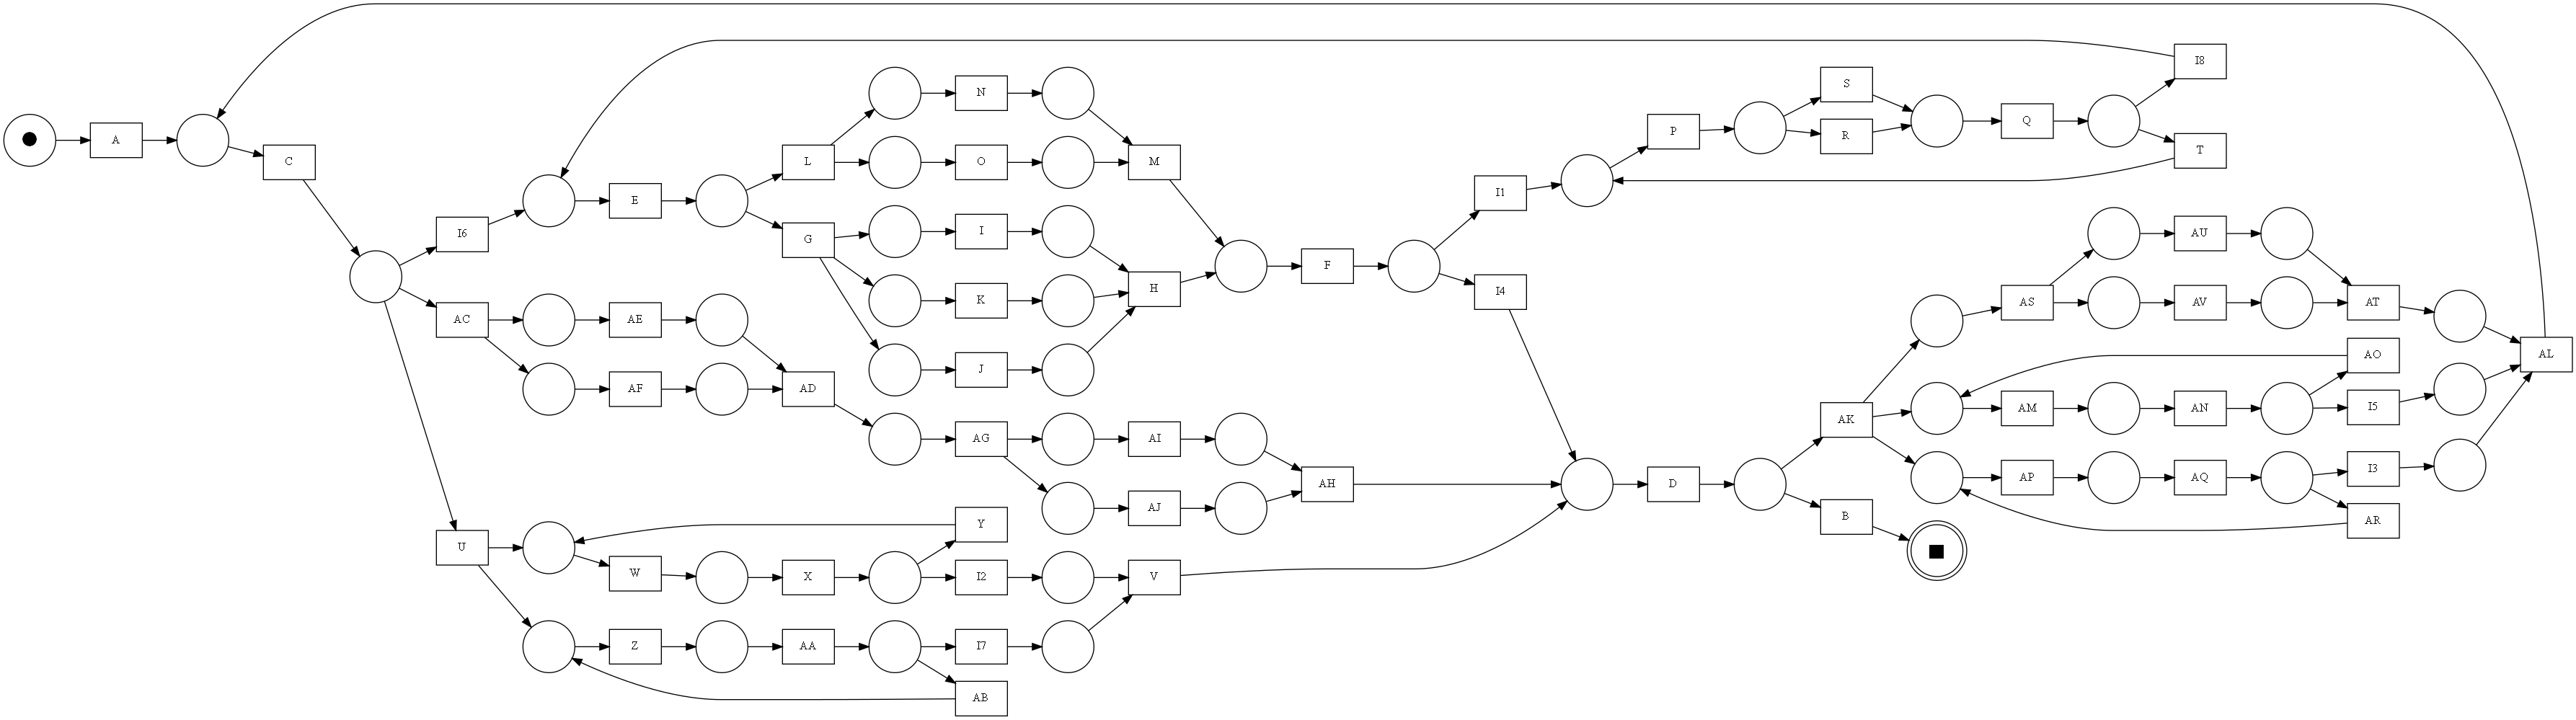

In [7]:
# 1. משכפלים את המאגר של “dice_server_version” כדי לקבל גם את הקבצים וגם את המודול icpm_experiments
!git clone https://github.com/elian204/dice_server_version.git

# 2. מוסיפים את השורש של המאגר אל sys.path כדי שיוכל לייבא את icpm_experiments
import sys
sys.path.append('/content/dice_server_version')

# 3. יבוא החבילות הנדרשות
import os
import re
import pm4py
from icpm_experiments import load_and_preprocess_log, generate_model_from_file
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# 4. פרמטרים
df_name       = 'pr-3-11-1151-A48_m50_l4_noise.csv'
subfolder     = 'pr'
# עכשיו הנתיב יחסי לתוך המאגר המקומי
data_repo_dir = r'c:\Users\Maor\Downloads\dice_server_version\Datasets'  # ✔ מעודכן

# 5. מייצרי שמות קבצים
base_match     = re.match(r'(pr-\d+-\d+-\d+-A\d+)_m\d+_l\d+_noise\.csv', df_name)
base_filename  = base_match.group(1) if base_match else None
model_filename = f"{base_filename}.txt"

csv_full_path   = os.path.join(data_repo_dir, subfolder, df_name)
model_full_path = os.path.join(data_repo_dir, subfolder, model_filename)

print("CSV file:  ", csv_full_path)
print("Model file:", model_full_path)

# 6. טען ותקנון הלוג מה־CSV
df, activity_mapping_dict = load_and_preprocess_log(
    df_name,
    min_len=None,
    max_len=None,
    n_traces=None,
    random_seed=42,
    path=data_repo_dir,
    subfolder=subfolder,
    max_samples_per_activity=None
)

# 7. בנה את המודל מתוך הקובץ TXT
model, init_marking, final_marking = generate_model_from_file(
    model_full_path,
    #activity_mapping_dict=activity_mapping_dict,
    return_markings=True
)

# 8. שלוף את המרכיבים של PM4Py
pm4py_net             = model.pm4py_net
pm4py_initial_marking = model.pm4py_initial_marking
pm4py_final_marking   = model.pm4py_final_marking

print(f"✅ pm4py Petri Net loaded with {len(pm4py_net.places)} places and {len(pm4py_net.transitions)} transitions")
print(f"✅ Initial marking: {pm4py_initial_marking}")
print(f"✅ Final   marking: {pm4py_final_marking}")

# 9. הצגת הרשת
gviz = pn_visualizer.apply(pm4py_net, pm4py_initial_marking, pm4py_final_marking)
pn_visualizer.view(gviz)

✅ Using CSV: pr-1-11-1244-A59_m17_l1.csv
✅ Model loaded with 71 places and 68 transitions
Initial marking: ['p_33:1']
Final marking:   ['end:1']


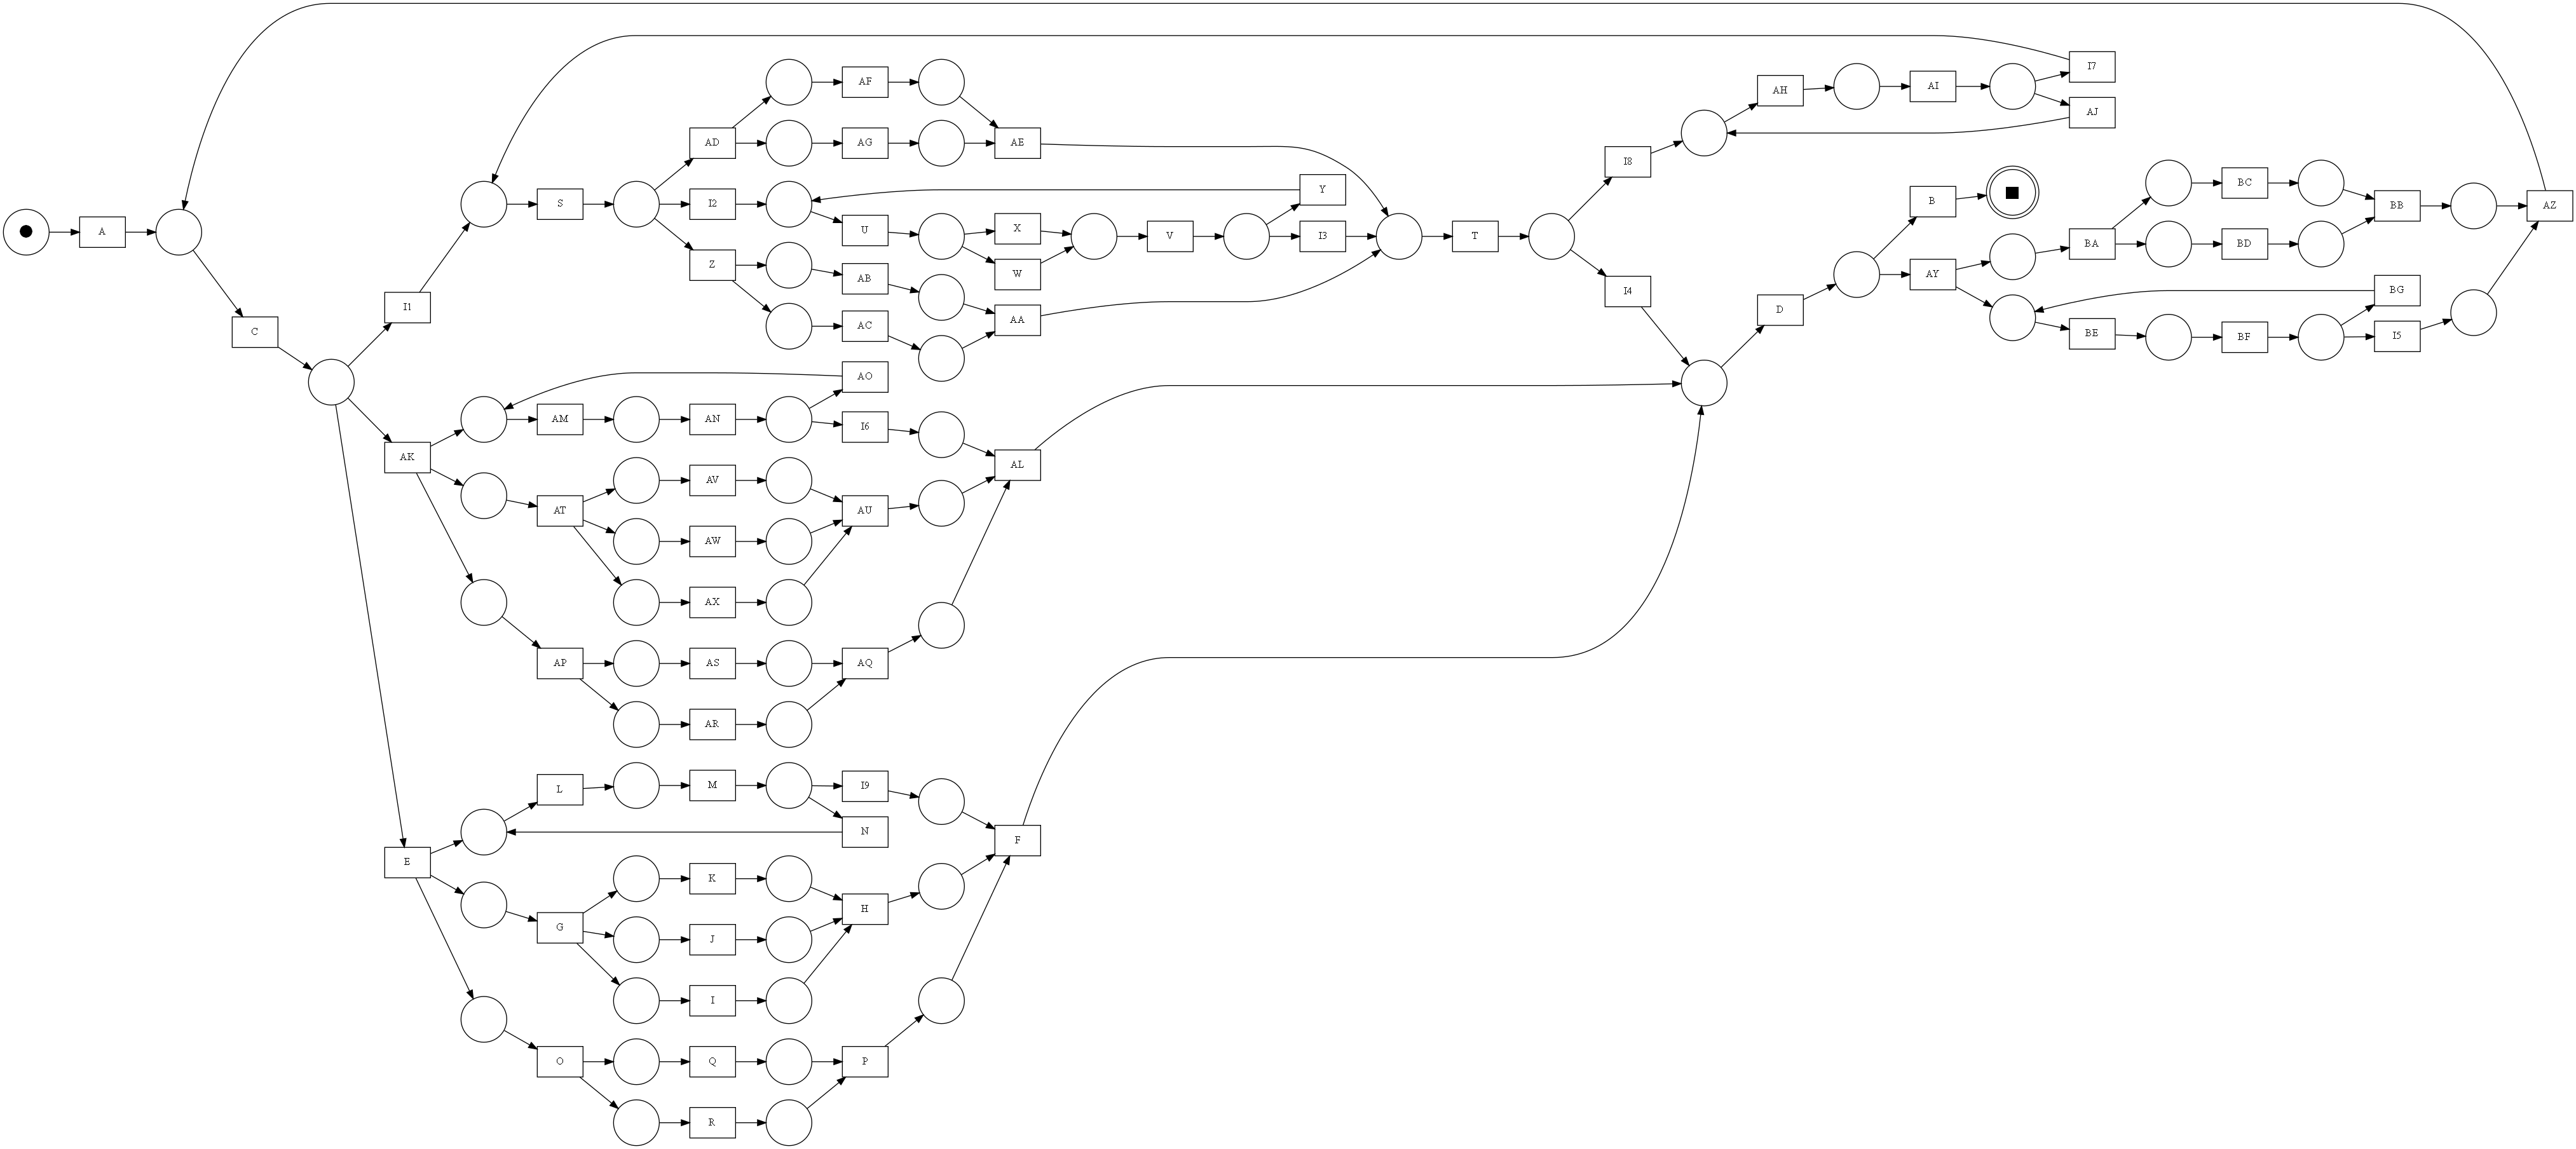

In [8]:
import os
import re
import sys
import pm4py
from icpm_experiments import load_and_preprocess_log, generate_model_from_file
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# 1. נתיב לשורש המאגר שלך
data_repo_dir = r'c:\Users\Maor\Downloads\dice_server_version\Datasets'
subfolder = 'pr'

# 2. שם בסיס המודל
base_name = 'pr-1-11-1244-A59'

# 3. חיפוש קובץ ה־CSV התואם
all_files = os.listdir(os.path.join(data_repo_dir, subfolder))
csv_candidates = [f for f in all_files if f.startswith(base_name) and f.endswith('.csv')]

if not csv_candidates:
    raise FileNotFoundError(f"No matching CSV file found for base name: {base_name}")

df_name = csv_candidates[0]  # לוקחים את הראשון שנמצא
print("✅ Using CSV:", df_name)

# 4. בניית נתיבים
csv_full_path   = os.path.join(data_repo_dir, subfolder, df_name)
model_filename  = base_name + '.txt'
model_full_path = os.path.join(data_repo_dir, subfolder, model_filename)

# 5. טעינת ה־CSV
df, activity_mapping_dict = load_and_preprocess_log(
    df_name,
    min_len=None,
    max_len=None,
    n_traces=None,
    random_seed=42,
    path=data_repo_dir,
    subfolder=subfolder,
    max_samples_per_activity=None
)

# 6. טעינת המודל
model, init_marking, final_marking = generate_model_from_file(
    model_full_path,
    return_markings=True
)

# 7. הצגת פרטים
pm4py_net             = model.pm4py_net
pm4py_initial_marking = model.pm4py_initial_marking
pm4py_final_marking   = model.pm4py_final_marking

print(f"✅ Model loaded with {len(pm4py_net.places)} places and {len(pm4py_net.transitions)} transitions")
print(f"Initial marking: {pm4py_initial_marking}")
print(f"Final marking:   {pm4py_final_marking}")

# 8. הצגת הרשת (יפתח חלון אם תומך או יציג בפורמט HTML)
gviz = pn_visualizer.apply(pm4py_net, pm4py_initial_marking, pm4py_final_marking)
pn_visualizer.view(gviz)


In [9]:
# 1. הורדת הקובץ ישירות מ-GitHub
!curl -L https://raw.githubusercontent.com/elian204/dice_server_version/main/Datasets/pr/pr-1-11-1244-A59_m55_l4_noise.csv \
      -o pr-1-11-1244-A59_m55_l4_noise.csv

# 2. טעינת pandas וסינון trace_1
import pandas as pd
from pm4py.objects.log.obj import Trace
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# הנחה: הפונקציות build_synchronous_product ו־build_example_model_2 כבר מוגדרות,
# וגם net2, init2 ו-final2 הוגדרו על ידך קודם

# טען את ה־CSV
df = pd.read_csv("pr-1-11-1244-A59_m55_l4_noise.csv")

# סנן את המאורעות של trace_1 ומיין לפי timestamp
trace_df = (
    df[df["case:concept:name"] == "trace_9"]
      .sort_values("time:timestamp")
)

# שלוף את רצף הפעילויות מהעמודה 'Activity'
trace = trace_df["Activity"].tolist()

# 3. בניית המודל הסינכרוני
sync_net, sync_marking = build_synchronous_product(pm4py_net, pm4py_initial_marking, trace)

# 4. הצגת רשת הפטרי הסינכרונית
gviz0 = pn_visualizer.apply(sync_net, sync_marking)
pn_visualizer.view(gviz0)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 20 9616k   20 1988k    0     0  1946k      0  0:00:04  0:00:01  0:00:03 1951k
 69 9616k   69 6652k    0     0  3290k      0  0:00:02  0:00:02 --:--:-- 3295k
100 9616k  100 9616k    0     0  3675k      0  0:00:02  0:00:02 --:--:-- 3678k


In [10]:
cost_map = {
    t.name: 0 if t.label.split(",")[0] == t.label.split(",")[1] else 1
    for t in sync_net.transitions
}

In [11]:
import numpy as np

def compute_sorted_incidence_matrix(net):
    places = list(net.places)
    transitions = list(net.transitions)

    # סיווג המעברים לפי סוגם
    move_model = []
    move_sync = []
    move_log = []

    for t in transitions:
        if ">>" in t.label and "," in t.label and t.label.endswith(">>"):
            move_model.append(t)
        elif ">>" in t.label and "," in t.label and t.label.startswith(">>"):
            move_log.append(t)
        elif "," in t.label and not ">>" in t.label:
            move_sync.append(t)
        else:
            # לא אמור לקרות אם הרשת נבנתה תקין
            continue

    # מיזוג כל המעברים לפי הסדר המבוקש
    sorted_transitions = move_model + move_sync + move_log

    # מיפוי שם מקום לאינדקס
    place_names = [p.name for p in places]
    place_index = {name: i for i, name in enumerate(place_names)}

    # יצירת מטריצת numpy ריקה
    matrix = np.zeros((len(places), len(sorted_transitions)), dtype=int)

    for j, t in enumerate(sorted_transitions):
        for arc in t.in_arcs:
            i = place_index[arc.source.name]
            matrix[i, j] -= 1
        for arc in t.out_arcs:
            i = place_index[arc.target.name]
            matrix[i, j] += 1

    return matrix, place_names, [t.name for t in sorted_transitions]

In [12]:
C_np, row_names, col_names = compute_sorted_incidence_matrix(sync_net)

print("Incidence Matrix (sorted):")
print(C_np)

print("\nTransition names (columns):")
print(col_names)

print("\nPlace names (rows):")
print(row_names)

Incidence Matrix (sorted):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Transition names (columns):
['L_M', 'AJ_M', 'AE_M', 'AF_M', 'BB_M', 'U_M', 'BA_M', 'BD_M', 'AT_M', 'K_M', 'AL_M', 'AM_M', 'B_M', 'I9_M', 'Z_M', 'BF_M', 'I3_M', 'I2_M', 'Q_M', 'N_M', 'AO_M', 'AQ_M', 'F_M', 'I6_M', 'T_M', 'AR_M', 'AH_M', 'AN_M', 'AC_M', 'I5_M', 'S_M', 'AY_M', 'BC_M', 'O_M', 'AU_M', 'J_M', 'G_M', 'I7_M', 'P_M', 'A_M', 'H_M', 'Y_M', 'BG_M', 'V_M', 'AW_M', 'D_M', 'AB_M', 'W_M', 'AZ_M', 'AP_M', 'X_M', 'M_M', 'AS_M', 'AV_M', 'AK_M', 'C_M', 'AA_M', 'I4_M', 'I1_M', 'R_M', 'AX_M', 'E_M', 'I_M', 'AG_M', 'AI_M', 'I8_M', 'AD_M', 'BE_M', 'I5_S_29', 'BB_S_30', 'C_S_2', 'AE_S_8', 'C_S_31', 'I1_S_3', 'AK_S_32', 'S_S_4', 'S_S_20', 'AA_S_24', 'AH_S_27', 'AC_S_22', 'Z_S_21', 'B_S_58', 'AZ_S_1', 'I4_S_26', 'AR_S_34', 'BC_S_13', 'AH_S_17', 'AX_S_38', 'AJ_S_16', 'AI_S_12', 'AJ_S_14', 'AH_S_11', 'AI_S_15', 'AT_S_36', 'AB_S_23', 'AI_S_18', 'T_S_25'

In [13]:
import numpy as np

def get_sync_initial_marking_vector(sync_net, model_marking, trace):
    place_names = [p.name for p in sync_net.places]
    vector = np.zeros(len(place_names), dtype=int)

    # נקבע סימון התחלתי רק אם המקום באמת קיים ברשת הסינכרונית
    for p, tokens in model_marking.items():
        place_name = f"{p.name}_m"
        if place_name in place_names:
            idx = place_names.index(place_name)
            vector[idx] = tokens

    # סימון לוג ראשוני
    log_place = "p0_l"
    if log_place in place_names:
        vector[place_names.index(log_place)] = 1

    return vector

def get_sync_final_marking(sync_net, model_final_marking, trace):
    place_names = [p.name for p in sync_net.places]
    vector = np.zeros(len(place_names), dtype=int)

    # רק מקומות סופיים שקיימים
    for p, tokens in model_final_marking.items():
        place_name = f"{p.name}_m"
        if place_name in place_names:
            idx = place_names.index(place_name)
            vector[idx] = tokens

    # סימון לוג סופי
    log_place = f"p{len(trace)}_l"
    if log_place in place_names:
        vector[place_names.index(log_place)] = 1

    return vector
m0 = get_sync_initial_marking_vector(sync_net, pm4py_initial_marking, trace)
mf = get_sync_final_marking(sync_net, pm4py_final_marking, trace)

print("m0 =", m0)
print("mf =", mf)


m0 = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
mf = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [14]:

import numpy as np
import pulp
import time

def build_incremental_lp(C, m0_vector, x, cost_map, mf, row_names, col_names):
    places = list(row_names)
    transitions = list(col_names)
    num_places = len(places)
    num_trans = len(transitions)

    prob = pulp.LpProblem("Incremental_Alignment", pulp.LpMinimize)

    # משתנה בינארי - האם מעבר t בוצע בצעד i
    """y = {
        (i, t): pulp.LpVariable(f"y_{i}_{t}", cat="Binary")
        for i in range(x) for t in range(num_trans)
    }"""

    y = {
    (i, t): pulp.LpVariable(f"y_{i}_{t}", lowBound=0, upBound=1, cat="Continuous")
    for i in range(x) for t in range(num_trans)
    }

    # משתנה של מספר הטוקנים בכל מקום לאחר כל צעד
    m = {
        (i, p): pulp.LpVariable(f"m_{i}_{places[p]}", lowBound=0, cat="Integer")
        for i in range(x + 1) for p in range(num_places)
    }

    # סימון התחלתי
    for p in range(num_places):
        prob += m[(0, p)] == m0_vector[p], f"initial_marking_p{p}"

    # פונקציית מטרה - עלות כוללת
    prob += pulp.lpSum([cost_map[transitions[t]] * y[(i, t)] for i in range(x) for t in range(num_trans)])

    for i in range(x):
        # בכל שלב בצע עד מעבר אחד בלבד
        prob += pulp.lpSum([y[(i, t)] for t in range(num_trans)]) <= 1, f"one_move_step_{i}"

        # אילוצי enabledness
        for t in range(num_trans):
            for p in range(num_places):
                if C[p, t] < 0:
                    prob += m[(i, p)] >= abs(C[p, t]) * y[(i, t)], f"enabled_check_p{p}_t{t}_step{i}"

        # עדכון הסימון
        for p in range(num_places):
            delta = pulp.lpSum([C[p, t] * y[(i, t)] for t in range(num_trans)])
            prob += m[(i + 1, p)] == m[(i, p)] + delta, f"marking_update_p{p}_step_{i}"

    # דרישת סימון סופי - חייב להיות מושג באחד מהשלבים
    for p in range(len(mf)):
        prob += m[(x, p)] == mf[p], f"final_marking_p{p}"

    return prob, y, m

In [15]:
print(trace)
print(len(trace))

['A', 'AZ', 'C', 'I1', 'S', 'AD', 'AF', 'AG', 'AE', 'T', 'I8', 'AH', 'AI', 'BC', 'AJ', 'AI', 'AJ', 'AH', 'AI', 'I7', 'S', 'Z', 'AC', 'AB', 'AA', 'T', 'I4', 'AH', 'D', 'I5', 'BB', 'C', 'AK', 'AP', 'AR', 'AM', 'AT', 'AN', 'AX', 'AW', 'AO', 'AV', 'AM', 'BF', 'AU', 'AS', 'AO', 'AQ', 'AM', 'AN', 'I6', 'AL', 'D', 'AY', 'BE', 'BD', 'BA', 'AN', 'B']
59


In [16]:
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments_algo

from pm4py.objects.log.obj import EventLog, Trace, Event
import time

# עטיפת ה-trace כאובייקט EventLog עם Trace אחד בלבד
trace_obj = Trace([{"concept:name": act} for act in trace])
event_log = EventLog()
event_log.append(trace_obj)

# מדידת זמן
start_astar = time.time()

# פתרון היישור באמצעות A*
alignment_result_list = alignments_algo.apply(
    event_log,
    pm4py_net,
    pm4py_initial_marking,
    pm4py_final_marking
)

end_astar = time.time()

# התוצאה היא רשימה (לכל טרייס תוצאה), אז ניקח את התוצאה הראשונה
alignment_result = alignment_result_list[0]

# הדפסת היישור
print("\n🔁 A* Alignment Result:")
for step in alignment_result["alignment"]:
    print(step)
    if step == ('>>', None):
        alignment_result['cost'] -= 1

print(f"\n✅ A* Cost: {alignment_result['cost']/10000}")
print(f"⏱ זמן פתרון A*: {end_astar - start_astar:.4f} שניות")



🔁 A* Alignment Result:
('A', 'A')
('AZ', '>>')
('C', 'C')
('I1', 'I1')
('S', 'S')
('AD', 'AD')
('AF', 'AF')
('AG', 'AG')
('AE', 'AE')
('T', 'T')
('I8', 'I8')
('AH', 'AH')
('AI', 'AI')
('BC', '>>')
('AJ', 'AJ')
('>>', 'AH')
('AI', 'AI')
('AJ', 'AJ')
('AH', 'AH')
('AI', 'AI')
('I7', 'I7')
('S', 'S')
('Z', 'Z')
('AC', 'AC')
('AB', 'AB')
('AA', 'AA')
('T', 'T')
('I4', 'I4')
('AH', '>>')
('D', 'D')
('>>', 'AY')
('>>', 'BE')
('>>', 'BF')
('>>', 'BA')
('I5', 'I5')
('>>', 'BC')
('>>', 'BD')
('BB', 'BB')
('>>', 'AZ')
('C', 'C')
('AK', 'AK')
('AP', 'AP')
('AR', 'AR')
('AM', 'AM')
('AT', 'AT')
('AN', 'AN')
('AX', 'AX')
('AW', 'AW')
('AO', 'AO')
('AV', 'AV')
('AM', 'AM')
('>>', 'AN')
('BF', '>>')
('AU', 'AU')
('AS', 'AS')
('AO', 'AO')
('AQ', 'AQ')
('AM', 'AM')
('AN', 'AN')
('I6', 'I6')
('AL', 'AL')
('D', 'D')
('AY', '>>')
('BE', '>>')
('BD', '>>')
('BA', '>>')
('AN', '>>')
('B', 'B')

✅ A* Cost: 18.0
⏱ זמן פתרון A*: 9.2486 שניות


In [17]:
#x = len(trace) + len(model_net.transitions)  # חסם עליון ריאלי
#x = len(trace) + len(pm4py_net.transitions)  # חסם עליון ריאלי
#x = 3 * len(trace)
#x = 2 * len(trace)
x = len(trace) + 10
prob, y_vars, m_vars = build_incremental_lp(C_np, m0, x, cost_map, mf, row_names, col_names)
start_lp = time.time()

prob.solve()

end_lp = time.time()
print(f"\n⏱ זמן פתרון LP: {end_lp - start_lp:.4f} שניות")

if pulp.LpStatus[prob.status] == "Optimal":
    alignment = []
    for i in range(x):
        for j, t_name in enumerate(col_names):
            if pulp.value(y_vars[(i, j)]) == 1:
                alignment.append(t_name)
                break

    markings = []
    for i in range(x + 1):
        marking_i = [int(pulp.value(m_vars[(i, p)])) for p in range(len(row_names))]
        markings.append(marking_i)

    print(f"\n✅ Alignment found with cost = {pulp.value(prob.objective)}")
    print("Alignment:")
    for i, t in enumerate(alignment):
        print(f"Step {i + 1}: {t}")
    print("\nMarkings:")
    for i, m in enumerate(markings):
        print(f"m_{i} = {m}")
else:
    print("❌ No feasible solution found.")


⏱ זמן פתרון LP: 20631.7571 שניות

✅ Alignment found with cost = 18.0
Alignment:
Step 1: A_S_0
Step 2: AZ_L_1
Step 3: C_S_2
Step 4: I1_S_3
Step 5: S_S_4
Step 6: AD_S_5
Step 7: AF_S_6
Step 8: AG_S_7
Step 9: AE_S_8
Step 10: T_S_9
Step 11: I8_S_10
Step 12: AH_S_11
Step 13: AI_S_12
Step 14: BC_L_13
Step 15: AJ_S_14
Step 16: AH_M
Step 17: AI_S_15
Step 18: AJ_S_16
Step 19: AH_S_17
Step 20: AI_S_18
Step 21: I7_S_19
Step 22: S_S_20
Step 23: Z_S_21
Step 24: AC_S_22
Step 25: AB_S_23
Step 26: AA_S_24
Step 27: T_S_25
Step 28: I4_S_26
Step 29: AH_L_27
Step 30: D_S_28
Step 31: AY_M
Step 32: BA_M
Step 33: BC_M
Step 34: BE_M
Step 35: BF_M
Step 36: I5_S_29
Step 37: BD_M
Step 38: BB_S_30
Step 39: AZ_M
Step 40: C_S_31
Step 41: AK_S_32
Step 42: AP_S_33
Step 43: AR_S_34
Step 44: AM_S_35
Step 45: AT_S_36
Step 46: AN_S_37
Step 47: AX_S_38
Step 48: AW_S_39
Step 49: AO_S_40
Step 50: AV_S_41
Step 51: AM_S_42
Step 52: AN_M
Step 53: BF_L_43
Step 54: AU_S_44
Step 55: AS_S_45
Step 56: AO_S_46
Step 57: AQ_S_47
Step 

In [6]:

c = ['L_M', 'AJ_M', 'AE_M', 'AF_M', 'BB_M', 'U_M', 'BA_M', 'BD_M', 'AT_M', 'K_M', 'AL_M', 'AM_M', 'B_M', 'I9_M', 'Z_M', 'BF_M', 'I3_M', 'I2_M', 'Q_M', 'N_M', 'AO_M', 'AQ_M', 'F_M', 'I6_M', 'T_M', 'AR_M', 'AH_M', 'AN_M', 'AC_M', 'I5_M', 'S_M', 'AY_M', 'BC_M', 'O_M', 'AU_M', 'J_M', 'G_M', 'I7_M', 'P_M', 'A_M', 'H_M', 'Y_M', 'BG_M', 'V_M', 'AW_M', 'D_M', 'AB_M', 'W_M', 'AZ_M', 'AP_M', 'X_M', 'M_M', 'AS_M', 'AV_M', 'AK_M', 'C_M', 'AA_M', 'I4_M', 'I1_M', 'R_M', 'AX_M', 'E_M', 'I_M', 'AG_M', 'AI_M', 'I8_M', 'AD_M', 'BE_M', 'I5_S_29', 'BB_S_30', 'C_S_2', 'AE_S_8', 'C_S_31', 'I1_S_3', 'AK_S_32', 'S_S_4', 'S_S_20', 'AA_S_24', 'AH_S_27', 'AC_S_22', 'Z_S_21', 'B_S_58', 'AZ_S_1', 'I4_S_26', 'AR_S_34', 'BC_S_13', 'AH_S_17', 'AX_S_38', 'AJ_S_16', 'AI_S_12', 'AJ_S_14', 'AH_S_11', 'AI_S_15', 'AT_S_36', 'AB_S_23', 'AI_S_18', 'T_S_25', 'AQ_S_47', 'T_S_9', 'D_S_52', 'I7_S_19', 'D_S_28', 'I6_S_50', 'BE_S_54', 'AW_S_39', 'AF_S_6', 'AY_S_53', 'AO_S_46', 'AN_S_37', 'AO_S_40', 'AU_S_44', 'AG_S_7', 'AM_S_48', 'A_S_0', 'AM_S_42', 'BF_S_43', 'BA_S_56', 'AL_S_51', 'AM_S_35', 'AN_S_49', 'AN_S_57', 'I8_S_10', 'AV_S_41', 'AD_S_5', 'AP_S_33', 'AS_S_45', 'BD_S_55', 'AC_L_22', 'T_L_25', 'D_L_28', 'C_L_31', 'AR_L_34', 'AD_L_5', 'AN_L_37', 'AE_L_8', 'AO_L_40', 'D_L_52', 'AH_L_11', 'BF_L_43', 'BD_L_55', 'C_L_2', 'AJ_L_14', 'AO_L_46', 'B_L_58', 'AH_L_17', 'AN_L_49', 'S_L_20', 'AB_L_23', 'I4_L_26', 'I5_L_29', 'AK_L_32', 'I1_L_3', 'AM_L_35', 'AF_L_6', 'AX_L_38', 'T_L_9', 'AV_L_41', 'AY_L_53', 'A_L_0', 'AI_L_12', 'AU_L_44', 'BA_L_56', 'AI_L_15', 'AQ_L_47', 'AI_L_18', 'I6_L_50', 'Z_L_21', 'AA_L_24', 'AH_L_27', 'BB_L_30', 'AP_L_33', 'S_L_4', 'AT_L_36', 'AG_L_7', 'AW_L_39', 'AL_L_51', 'I8_L_10', 'AM_L_42', 'BE_L_54', 'AZ_L_1', 'BC_L_13', 'AS_L_45', 'AN_L_57', 'AJ_L_16', 'AM_L_48', 'I7_L_19']

r = ['p_4_m', 'p_3_m', 'p3_l', 'p31_l', 'p_70_m', 'p_14_m', 'p_52_m', 'p_67_m', 'p10_l', 'p38_l', 'p_21_m', 'p_44_m', 'p_27_m', 'p17_l', 'p45_l', 'p_7_m', 'p_48_m', 'p24_l', 'p52_l', 'p_24_m', 'p_22_m', 'p59_l', 'p_62_m', 'p_57_m', 'p_41_m', 'p6_l', 'p34_l', 'p_29_m', 'p_23_m', 'p13_l', 'p41_l', 'p_63_m', 'p_39_m', 'p20_l', 'p48_l', 'p_20_m', 'p_6_m', 'p27_l', 'p55_l', 'p_36_m', 'p_26_m', 'p2_l', 'p30_l', 'p_10_m', 'p_60_m', 'p_55_m', 'p9_l', 'p37_l', 'p_40_m', 'p_16_m', 'p16_l', 'p44_l', 'p_59_m', 'p_5_m', 'p_64_m', 'p23_l', 'p51_l', 'p_17_m', 'p_19_m', 'p58_l', 'p_65_m', 'p_38_m', 'p5_l', 'p33_l', 'p_18_m', 'p_2_m', 'p12_l', 'p40_l', 'p_54_m', 'p_35_m', 'p19_l', 'p47_l', 'p_53_m', 'p_68_m', 'p26_l', 'p54_l', 'p1_l', 'p_31_m', 'p_15_m', 'p29_l', 'p_69_m', 'p_47_m', 'p8_l', 'p36_l', 'p_37_m', 'p_12_m', 'p15_l', 'p43_l', 'p_58_m', 'p_56_m', 'p22_l', 'p50_l', 'p_13_m', 'p_8_m', 'p57_l', 'p_43_m', 'p_34_m', 'p4_l', 'p32_l', 'p_25_m', 'p_9_m', 'p11_l', 'p39_l', 'p_46_m', 'p_30_m', 'p18_l', 'p46_l', 'p_61_m', 'end_m', 'p25_l', 'p53_l', 'p_50_m', 'p_28_m', 'p_11_m', 'p0_l', 'p28_l', 'p_49_m', 'p_45_m', 'p7_l', 'p35_l', 'p_32_m', 'p_33_m', 'p14_l', 'p42_l', 'p_66_m', 'p_42_m', 'p21_l', 'p49_l', 'p_0_m', 'p_51_m', 'p56_l']
len(c)

186